In [1]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)

#Function to generate a 3-panel plot for input arrays
def plot2panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)


In [2]:
#! /usr/bin/env python
"""
Compute dh/dt and mass balance for input DEMs and glacier polygons
"""

"""
Todo:
GDAL_MAX_DATASET_POOL_SIZE - set to large number of open datasets in vrt
Better error estimates - use buffered dz/dt and semivariogram
Filling gaps using 1) dz/dt obs 2) setting to 0 around polygon margins
Curves for PRISM T an precip vs. mb
Move mb_plot_gpd funcitonality here, export polygons with mb numbers as geojson, spatialite, shp?
Add +/- std for each dh/dt polygon, some idea of spread
Create main function, pass args to mb_proc
Clean up mb_proc function, one return, globals
Better penetration correction
"""

import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib

#Avoid printing out divide by 0 errors
np.seterr(all='ignore')

"""
Class to store relevant feature attributes and derived values
Safe for multiprocessing
"""
class GlacFeat:
    def __init__(self, feat, glacname_fieldname, glacnum_fieldname):

        self.glacname = feat.GetField(glacname_fieldname)
        if self.glacname is None:
            self.glacname = ""
        else:
            #RGI has some nonstandard characters
            #self.glacname = self.glacname.decode('unicode_escape').encode('ascii','ignore')
            #glacname = re.sub(r'[^\x00-\x7f]',r'', glacname)
            self.glacname = re.sub(r'\W+', '', self.glacname)
            self.glacname = self.glacname.replace(" ", "")
            self.glacname = self.glacname.replace("_", "")
            self.glacname = self.glacname.replace("/", "")

        self.glacnum = feat.GetField(glacnum_fieldname)
        fn = feat.GetDefnRef().GetName()
        #RGIId (String) = RGI50-01.00004
        self.glacnum = '%0.5f' % float(self.glacnum.split('-')[-1])

        if self.glacname:
            self.feat_fn = "%s_%s" % (self.glacnum, self.glacname)
        else:
            self.feat_fn = str(self.glacnum)

        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        #Hack to deal with fact that this is not preserved in geom when loaded from pickle on disk
        self.glac_geom_srs_wkt = self.glac_geom.GetSpatialReference().ExportToWkt()

        #Attributes written by mb_calc
        self.z1 = None
        self.z1_hs = None
        self.z1_stats = None
        self.z1_ela = None
        self.z2 = None
        self.z2_hs = None
        self.z2_stats = None
        self.z2_ela = None
        self.z2_aspect = None
        self.z2_aspect_stats = None
        self.z2_slope = None
        self.z2_slope_stats = None
        self.res = None
        self.dhdt = None
        self.mb = None
        self.mb_mean = None
        self.t1 = None
        self.t2 = None
        self.dt = None
        self.t1_mean = None
        self.t2_mean = None
        self.dt_mean = None

        self.H = None
        self.H_mean = np.nan
        self.vx = None
        self.vy = None
        self.vm = None
        self.vm_mean = np.nan
        self.divQ = None
        self.debris_class = None
        self.debris_thick = None
        self.debris_thick_mean = np.nan
        self.perc_clean = np.nan
        self.perc_debris = np.nan
        self.perc_pond = np.nan

    def geom_srs_update(self, srs=None):
        if self.glac_geom.GetSpatialReference() is None:
            if srs is None:
                srs = osr.SpatialReference()
                srs.ImportFromWkt(self.glac_geom_srs_wkt)
            self.glac_geom.AssignSpatialReference(srs)

    def geom_attributes(self, srs=None):
        self.geom_srs_update()
        if srs is not None:
            #Should reproject here to equal area, before geom_attributes
            #self.glac_geom.AssignSpatialReference(glac_shp_srs)
            #self.glac_geom_local = geolib.geom2localortho(self.glac_geom)
            geolib.geom_transform(self.glac_geom, srs)

        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        self.glac_area = self.glac_geom.GetArea()
        self.glac_area_km2 = self.glac_area / 1E6
        self.cx, self.cy = self.glac_geom.Centroid().GetPoint_2D()

def srtm_corr(z):
    #Should separate into different regions from Kaab et al (2012)
    #Should separate into firn/snow, clean ice, and debris-covered ice

    #For now, use Kaab et al (2012) region-wide mean of 2.1 +/- 0.4
    offset = 2.1
    return z + offset

def z_vs_dz(z,dz):
    plt.scatter(z.compressed(), dz.compressed())

#RGI uses 50 m bins
def hist_plot(gf, outdir, bin_width=50.0, dz_clim=(-2.0, 2.0)):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc

    #Create arrays to store output
    mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
    np.ma.set_fill_value(mb_bin_med, np.nan)
    mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
    mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
    mb_bin_std = np.ma.masked_all_like(mb_bin_med)
    dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
    dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
    dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
    dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
    dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(mb_bin_med)
        vm_bin_mad = np.ma.masked_all_like(mb_bin_med)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(mb_bin_med)
        H_bin_std = np.ma.masked_all_like(mb_bin_med)
    if gf.debris_class is not None:
        perc_clean = np.ma.masked_all_like(mb_bin_med)
        perc_debris = np.ma.masked_all_like(mb_bin_med)
        perc_pond = np.ma.masked_all_like(mb_bin_med)
        debris_thick_med = np.ma.masked_all_like(mb_bin_med)
        debris_thick_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_clean_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_debris_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_pond_bin_med = np.ma.masked_all_like(mb_bin_med)

        gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
        gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
        gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
        if mb_bin_samp.count() > min_bin_samp_count:
            mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
            mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
            mb_bin_mean[bin_n] = mb_bin_samp.mean()
            mb_bin_std[bin_n] = mb_bin_samp.std()
        dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
        if dhdt_bin_samp.count() > min_bin_samp_count:
            dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
            dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
            dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
            dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
            dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()

    dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
    #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
    dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m, z1_bin_count_valid, z1_bin_area_valid_km2, z1_bin_area_perc, z2_bin_count_valid, z2_bin_area_valid_km2, z2_bin_area_perc, dhdt_bin_count, dhdt_bin_area_valid_km2, dhdt_bin_area_perc, dhdt_bin_med_ma, dhdt_bin_mad_ma, dhdt_bin_mean_ma, dhdt_bin_std_ma, mb_bin_med_mwea, mb_bin_mad_mwea, mb_bin_mean_mwea, mb_bin_std_mwea'
    fmt = '%0.1f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, \
            dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
            mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std]

    if gf.debris_thick is not None:
        outbins_header += ', debris_thick_med_m, debris_thick_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    if gf.debris_class is not None:
        outbins_header += ', perc_debris, perc_pond, perc_clean, dhdt_debris_med, dhdt_pond_med, dhdt_clean_med'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ', vm_med, vm_mad'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
        outbins_header += ', H_mean, H_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([H_bin_mean, H_bin_std])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    outbins_fn = os.path.join(outdir, gf.feat_fn+'_mb_bins.csv')
    np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)

    #Create plots of elevation bins
    #print("Generating aed plot")
    #f,axa = plt.subplots(1,2, figsize=(6, 6))
    f,axa = plt.subplots(1,4, figsize=(10, 7.5))
    f.suptitle(gf.feat_fn)
    fs = 9

    axa[0].plot(z1_bin_areas, z_bin_centers, label='%0.2f' % gf.t1_mean)
    axa[0].axhline(gf.z1_ela, ls=':', c='C0')
    if gf.z2 is not None:
        axa[0].plot(z2_bin_areas, z_bin_centers, label='%0.2f' % gf.t2_mean)
        axa[0].axhline(gf.z2_ela, ls=':', c='C1')
    axa[0].legend(prop={'size':8}, loc='upper right')
    axa[0].set_ylabel('Elevation (m WGS84)', fontsize=fs)
    axa[0].set_xlabel('Area $\mathregular{km^2}$', fontsize=fs)
    axa[0].yaxis.set_ticks_position('both')
    # pltlib.minorticks_on(axa[0])

    axa[1].axvline(0, lw=1.0, c='k')
    """
    #Plot flux divergence values for each bin
    if gf.vm is not None and gf.H is not None:
        divQ_bin_mean = np.gradient(H_bin_mean * vm_bin_med * v_col_f)
        axa[1].plot(divQ_bin_mean, z_bin_centers, color='green')
    """
    axa[1].plot(mb_bin_med, z_bin_centers, color='k')
    axa[1].axvline(gf.mb_mean, lw=0.5, ls=':', c='k', label='%0.2f m w.e./yr' % gf.mb_mean)
    axa[1].fill_betweenx(z_bin_centers, mb_bin_med-mb_bin_mad, mb_bin_med+mb_bin_mad, color='k', alpha=0.1)
    axa[1].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med<0), color='r', alpha=0.2)
    axa[1].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med>0), color='b', alpha=0.2)
    #axa[1].set_xlabel('dh/dt (m/yr)')
    axa[1].set_xlabel('Mass balance (m w.e./yr)', fontsize=fs)
    axa[1].legend(prop={'size':8}, loc='upper right')
    axa[1].yaxis.set_ticks_position('both')
    # pltlib.minorticks_on(axa[1])
    #Hide y-axis labels
    axa[1].axes.yaxis.set_ticklabels([])
    axa[1].set_xlim(*dz_clim)

    if gf.debris_thick is not None:
        axa[2].errorbar(debris_thick_med*100., z_bin_centers, xerr=debris_thick_mad*100, color='k', fmt='o', ms=3, label='Debris Thickness', alpha=0.6)
    if gf.debris_class is not None:
        axa[2].plot(perc_debris, z_bin_centers, color='sienna', label='Debris Coverage')
        axa[2].plot(perc_pond, z_bin_centers, color='turquoise', label='Pond Coverage')
    if gf.debris_thick is not None or gf.debris_class is not None:
        axa[2].set_xlim(0, 100)
        axa[2].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[2])
        axa[2].axes.yaxis.set_ticklabels([])
        axa[2].legend(prop={'size':8}, loc='upper right')
        axa[2].set_xlabel('Debris thickness (cm), coverage (%)', fontsize=fs)

    if gf.vm is not None:
        ax4 = axa[3].twinx()
        ax4.set_xlabel('Velocity (m/yr)', fontsize=fs)
        ax4.plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
        ax4.fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
        #ax4.set_xlim(0, 50)
        ax4.xaxis.tick_top()
        ax4.xaxis.set_label_position("top")
        ax4.legend(prop={'size':8}, loc='upper right')

    if gf.H is not None:
        axa[3].plot(H_bin_mean, z_bin_centers, color='b', label='H (%0.2f m)' % gf.H_mean)
        axa[3].fill_betweenx(z_bin_centers, H_bin_mean-H_bin_std, H_bin_mean+H_bin_std, color='b', alpha=0.1)
        axa[3].set_xlabel('Ice Thickness (m)', fontsize=fs)
        axa[3].legend(prop={'size':8}, loc='lower right')
        # pltlib.minorticks_on(axa[3])
        #axa[3].set_xlim(0, 400)
        axa[3].yaxis.tick_right()
        axa[3].yaxis.set_ticks_position('both')
        axa[3].yaxis.set_label_position("right")

    plt.tight_layout()
    #Make room for suptitle
    plt.subplots_adjust(top=0.95, wspace=0.1)
    #print("Saving aed plot")
    fig_fn = os.path.join(outdir, gf.feat_fn+'_mb_aed.png')
    #plt.savefig(fig_fn, bbox_inches='tight', dpi=300)
    plt.savefig(fig_fn, dpi=300)
    plt.close(f)
    return z_bin_edges

def map_plot(gf, z_bin_edges, outdir, hs=True, dz_clim=(-2.0, 2.0)):
    #print("Generating map plot")
    f,axa = plt.subplots(1,3, figsize=(10,7.5))
    #f.suptitle(gf.feat_fn)
    alpha = 1.0
    if hs:
        #z1_hs = geolib.gdaldem_wrapper(gf.out_z1_fn, product='hs', returnma=True, verbose=False)
        #z2_hs = geolib.gdaldem_wrapper(gf.out_z2_fn, product='hs', returnma=True, verbose=False)
        z1_hs = gf.z1_hs
        z2_hs = gf.z2_hs
        hs_clim = malib.calcperc(z2_hs, (2,98))
        z1_hs_im = axa[0].imshow(z1_hs, cmap='gray', vmin=hs_clim[0], vmax=hs_clim[1])
        z2_hs_im = axa[1].imshow(z2_hs, cmap='gray', vmin=hs_clim[0], vmax=hs_clim[1])
        alpha = 0.5
    z1_im = axa[0].imshow(gf.z1, cmap='cpt_rainbow', vmin=z_bin_edges[0], vmax=z_bin_edges[-1], alpha=alpha)
    z2_im = axa[1].imshow(gf.z2, cmap='cpt_rainbow', vmin=z_bin_edges[0], vmax=z_bin_edges[-1], alpha=alpha)
    axa[0].contour(gf.z1, [gf.z1_ela,], linewidths=0.5, linestyles=':', colors='w')
    axa[1].contour(gf.z2, [gf.z2_ela,], linewidths=0.5, linestyles=':', colors='w')
    #t1_title = int(np.round(gf.t1))
    #t2_title = int(np.round(gf.t2))
    t1_title = '%0.2f' % gf.t1_mean
    t2_title = '%0.2f' % gf.t2_mean
    #t1_title = gf.t1.strftime('%Y-%m-%d')
    #t2_title = gf.t2.strftime('%Y-%m-%d')
    axa[0].set_title(t1_title)
    axa[1].set_title(t2_title)
    axa[2].set_title('%s to %s (%0.2f yr)' % (t1_title, t2_title, gf.dt_mean))
    dz_im = axa[2].imshow(gf.dhdt, cmap='RdBu', vmin=dz_clim[0], vmax=dz_clim[1])
    for ax in axa:
        # pltlib.hide_ticks(ax)
        ax.set_facecolor('k')
    # sb_loc = pltlib.best_scalebar_location(gf.z1)
    # pltlib.add_scalebar(axa[0], gf.res[0], location=sb_loc)
    # pltlib.add_cbar(axa[0], z1_im, label='Elevation (m WGS84)')
    # pltlib.add_cbar(axa[1], z2_im, label='Elevation (m WGS84)')
    # pltlib.add_cbar(axa[2], dz_im, label='dh/dt (m/yr)')
    plt.tight_layout()
    #Make room for suptitle
    #plt.subplots_adjust(top=0.90)
    #print("Saving map plot")
    fig_fn = os.path.join(outdir, gf.feat_fn+'_mb_map.png')
    plt.savefig(fig_fn, dpi=300)
    plt.close(f)

def get_date_a(ds, date_shp_lyr, glac_geom_mask, datefield):
    date_r_ds = iolib.mem_drv.CreateCopy('', ds)
    #Shapefile order should be sorted by time, but might want to think about sorting here
    #Can automatically search for datefield
    gdal.RasterizeLayer(date_r_ds, [1], date_shp_lyr, options=["ATTRIBUTE=%s" % datefield])
    date_a = np.ma.array(iolib.ds_getma(date_r_ds), mask=glac_geom_mask)
    #Note: NED dates are in integer years, assume source imagery was flown in late summer for mountains
    if datefield == 'S_DATE_CLN':
        date_a += 0.75
    return date_a

"""
#Consider storing setup variables in dictionary that can be passed to Process
setup = {}
setup['site'] = site
"""

topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
site = 'Braun_PCR07N'
# Braun options: ['Braun_PCR07N', 'Braun_PCR08N', 'Braun_PCR09N']
# site='StElias'
# site = 'Chugach'
# site = 'AR_W'
# site = 'AR_C'
# site = 'AR_E'
# site = 'Coast'
# site = 'Kenai'
# site = 'AK_Pen'
# Berthier options: ['StElias', 'Chugach', 'AR_W', 'AR_C', 'AR_E', 'Coast', 'Kenai', 'AK_Pen', 'HMA']

#Filter glacier poly - let's stick with big glaciers for no
# min_glac_area = 0.0 #km^2
#min_glac_area = 0.1 #km^2
min_glac_area = 0 #km^2
# min_glac_area = 2. #km^2
#Only write out for larger glaciers
min_glac_area_writeout = 1.
#Minimum percentage of glacier poly covered by valid dz
min_valid_area_perc = 0.6       # DSHEAN WAS 0.85
#Process thickness, velocity, etc
extra_layers = False            # DSHEAN WAS TRUE
#Write out DEMs and dz map
writeout = True
#Generate figures
mb_plot = True
#Run in parallel, set to False for serial loop
parallel = False
#Verbose for debugging
verbose = True
#Number of parallel processes
#Use all virtual cores
#nproc = iolib.cpu_count(logical=True) - 1
#Use all physical cores
# nproc = iolib.cpu_count(logical=False) - 1
nproc = 1
#Shortcut to use existing glacfeat_list.p if found
use_existing_glacfeat = True

#Pad by this distance (meters) around glacier polygon for uncertainty estimates over surrounding surfaces
buff_dist = 1000

#Bin width
bin_width = 50

#Surface to column average velocity scaling
v_col_f = 0.8

#This is recommendation by Huss et al (2013)
rho_is = 0.85
rho_sigma = 0.06

#If breaking down into accumulation vs. ablation area
#rho_i = 0.91
#rho_s = 0.50
#rho_f = 0.60

#Fountain
#Other sources Kaab et al (2012) use 0.1
area_sigma_perc = 0.09

global z1_date
global z2_date
z1_date = None
z2_date = None
z1_srtm_penetration_corr = False
z2_srtm_penetration_corr = False


if site in ['Braun_PCR07N', 'Braun_PCR08N', 'Braun_PCR09N']:
    #Output directory
    outdir = topdir + 'Braun/output/'
    outdir_fig = topdir + 'Braun/output/figures/'
    outdir_csv = topdir + 'Braun/output/csv/'

    glac_shp_fn = topdir + '../RGI/rgi60/01_rgi60_Alaska/01_rgi60_Alaska.shp'
    glacfeat_fn = outdir + site + '_glacfeat_list.p'

    # Filenames
    z1_fn_dict = {'Braun_PCR07N': topdir + 'Braun/TDX-SRTM_prelim/NorthAmerica_dhdt/region_03_PCRn/srtm_filled_ice__03_PCRn-utm07N-strips_crp2reg_03_PCRn.tif',
                  'Braun_PCR08N': topdir + 'Braun/TDX-SRTM_prelim/NorthAmerica_dhdt/region_03_PCRn/srtm_filled_ice__03_PCRn-utm08N-strips_crp2reg_03_PCRn.tif',
                  'Braun_PCR09N': topdir + 'Braun/TDX-SRTM_prelim/NorthAmerica_dhdt/region_03_PCRn/srtm_filled_ice__03_PCRn-utm09N-strips_crp2reg_03_PCRn.tif'}
    z1_date_dict = 2000.128
    z2_fn_dict = None
    z2_date_dict = 2012.0
    dhdt_fn_dict = {'Braun_PCR07N': topdir + 'Braun/TDX-SRTM_prelim/NorthAmerica_dhdt/region_03_PCRn/dh_dt_on_ice__03_PCRn-utm07N-strips_crp2reg_03_PCRn.tif',
                    'Braun_PCR08N': topdir + 'Braun/TDX-SRTM_prelim/NorthAmerica_dhdt/region_03_PCRn/dh_dt_on_ice__03_PCRn-utm08N-strips_crp2reg_03_PCRn.tif',
                    'Braun_PCR09N': topdir + 'Braun/TDX-SRTM_prelim/NorthAmerica_dhdt/region_03_PCRn/dh_dt_on_ice__03_PCRn-utm09N-strips_crp2reg_03_PCRn.tif'}
    
    
    z1_fn = z1_fn_dict[site]
    z1_date = z1_date_dict
    z1_sigma = 10
    z1_srtm_penetration_corr = False

    if z2_fn_dict is None:
        dhdt_fn = dhdt_fn_dict[site]
    else:
        z2_fn = z2_fn_dict[site]
    z2_date = z2_date_dict
    z2_sigma = 10
    z2_srtm_penetration_corr = False
    

    #Output projection
    #'+proj=aea +lat_1=25 +lat_2=47 +lat_0=36 +lon_0=85 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '
    # print('\n\nSHOULD CHANGE TO EQUAL AREA PROJECTION!\n\n')
    # aea_srs = geolib.hma_aea_srs
    ds = gdal.Open(z1_fn)
    prj = ds.GetProjection()
    srs = osr.SpatialReference(wkt=prj)
    aea_srs = srs

    #Surface velocity
    # add surface velocities where possible?

    print('\nStatic analysis does not work for quantifying uncertainty because clipped by RGI extents')
    print('\nOpting to use UTM projections to avoid errors caused by projecting/resampling datasets\n')



Static analysis does not work for quantifying uncertainty because clipped by RGI extents

Opting to use UTM projections to avoid errors caused by projecting/resampling datasets




Warping all inputs to the following:
Resolution: 30.0
Extent: [537155.67713055, 6545401.2408929, 695675.67713055, 6657601.2408929]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Braun/TDX-SRTM_prelim/NorthAmerica_dhdt/region_03_PCRn/srtm_filled_ice__03_PCRn-utm07N-strips_crp2reg_03_PCRn.tif
nl: 3740 ns: 5284 res: 30.000
2 of 2: /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Braun/TDX-SRTM_prelim/NorthAmerica_dhdt/region_03_PCRn/dh_dt_on_ice__03_PCRn-utm07N-strips_crp2reg_03_PCRn.tif


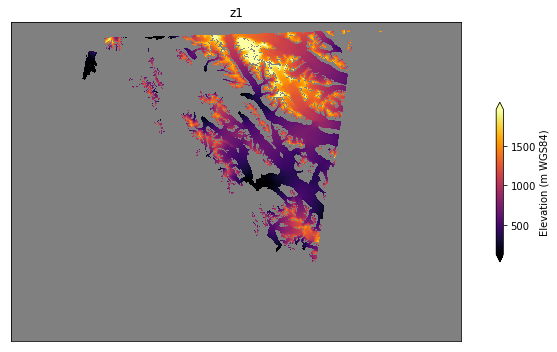

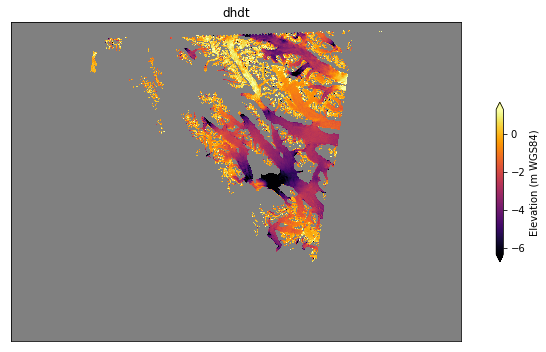

In [3]:
# Hack to be able to use Shean processing scripts for MB and binning calcs with Braun data
#Warp everything to common res/extent/proj
ds_list = warplib.memwarp_multi_fn([z1_fn, dhdt_fn], 
                                   res='min', t_srs=aea_srs, verbose=verbose, r='cubic')
# DEM masks
ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
z1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
dhdt = ds_list_masked[1]

titles = ['z1']
clim = malib.calcperc(z1, (2,98))
plot_array(z1, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='z1.png')

titles = ['dhdt']
clim = malib.calcperc(dhdt, (2,98))
plot_array(dhdt, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='z1.png')


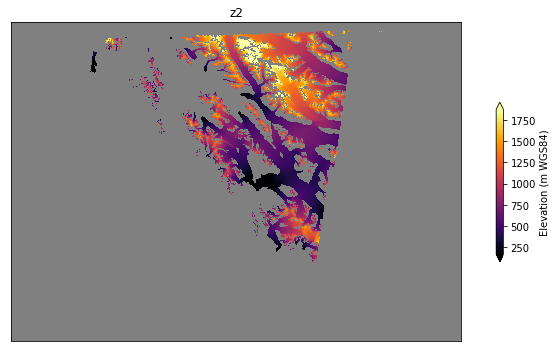

In [7]:
z2 = z1 + dhdt
z2.mask = np.ma.mask_or(z1.mask, dhdt.mask)

titles = ['z2']
clim = malib.calcperc(z2, (2,98))
plot_array(z2, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='z2.png')

In [33]:
z2_fn = z1_fn.replace('srtm_filled_ice', 'z2_fromSTRM&dhdt')

with rasterio.open(dhdt_fn) as src:
    profile = src.profile.copy()
    print(profile)

    print('\n\n')


    with rasterio.open(z2_fn, 'w', **profile) as dst:
        source=rasterio.band(src, 1)
        destination=rasterio.band(dst, 1)
        src_transform=src.transform
        src_crs=src.crs

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 5284, 'height': 3740, 'count': 1, 'crs': CRS.from_epsg(32607), 'transform': Affine(30.0, 0.0, 537155.67713055,
       0.0, -30.0, 6657601.2408929), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}





In [ ]:
# elif site in ['StElias', 'Chugach', 'AR_W', 'AR_C', 'AR_E', 'Coast', 'Kenai', 'AK_Pen']:
#     #Output directory
#     outdir = topdir + 'Berthier/output/'
#     outdir_fig = topdir + 'Berthier/output/figures/'
#     outdir_csv = topdir + 'Berthier/output/csv'

#     glac_shp_fn = topdir + '../RGI/rgi60/01_rgi60_Alaska/01_rgi60_Alaska.shp'
#     glacfeat_fn = outdir + site + '_glacfeat_list.p'

#     #ASTER+WV trend interp 2008
#     z1_fn_dict = {'StElias': topdir + 'Berthier/Alaska_1950_2006/1.StElias/StElias_Map_DEM.tif',
#                   'Chugach': topdir + 'Berthier/Alaska_1950_2006/2.Chugach/Chugach_Map_DEM.tif',
#                   'AR_W': topdir + 'Berthier/Alaska_1950_2006/3.AR_W/AR_W_Map_DEM.tif',
#                   'AR_C': topdir + 'Berthier/Alaska_1950_2006/4.AR_C/AR_C_Map_DEM.tif',
#                   'AR_E': topdir + 'Berthier/Alaska_1950_2006/5.AR_E/AR_E_Map_DEM.tif',
#                   'Coast': topdir + 'Berthier/Alaska_1950_2006/6.Coast/Coast_Map_DEM.tif',
#                   'Kenai': topdir + 'Berthier/Alaska_1950_2006/7.Kenai/Kenai_Map_DEM.tif',
#                   'AK_Pen': topdir + 'Berthier/Alaska_1950_2006/8.AK_Peninsula/AK_Peninsula_Map_DEM.tif',}
#     z1_date_dict = {'StElias': 1968.,
#                     'Chugach': 1954.,
#                     'AR_W': 1953.,
#                     'AR_C': 1953.,
#                     'AR_E': 1953.,
#                     'Coast': 1966.,
#                     'Kenai': 1950.,
#                     'AK_Pen': 1950.}
#     z2_fn_dict = {'StElias': topdir + 'Berthier/Alaska_1950_2006/1.StElias/StElias_Satellite_DEM.tif',
#                   'Chugach': topdir + 'Berthier/Alaska_1950_2006/2.Chugach/Chugach_Sat_DEM.tif',
#                   'AR_W': topdir + 'Berthier/Alaska_1950_2006/3.AR_W/AR_W_Sat_DEM.tif',
#                   'AR_C': topdir + 'Berthier/Alaska_1950_2006/4.AR_C/AR_C_Sat_DEM.tif',
#                   'AR_E': topdir + 'Berthier/Alaska_1950_2006/5.AR_E/AR_E_Sat_DEM.tif',
#                   'Coast': topdir + 'Berthier/Alaska_1950_2006/6.Coast/Coast_Sat_DEM.tif',
#                   'Kenai': topdir + 'Berthier/Alaska_1950_2006/7.Kenai/Kenai_Sat_DEM.tif',
#                   'AK_Pen': topdir + 'Berthier/Alaska_1950_2006/8.AK_Peninsula/AK_Peninsula_Sat_DEM.tif',}
#     z2_date_dict = {'StElias': 2006.75,
#                     'Chugach': 2006.75,
#                     'AR_W': 2004.75,
#                     'AR_C': 2004.75,
#                     'AR_E': 2004.75,
#                     'Coast': 2007.75,
#                     'Kenai': 2007.75,
#                     'AK_Pen': 2007.75}


#     # z1_fn = topdir + 'Berthier/Alaska_1950_2006/1.StElias/StElias_Map_DEM.tif'
#     z1_fn = z1_fn_dict[site]
#     z1_date = z1_date_dict[site]
#     z1_sigma = 10
#     z1_srtm_penetration_corr = False

#     #WV trend interp 2018
#     # z2_fn = topdir + 'Berthier/Alaska_1950_2006/1.StElias/StElias_Satellite_DEM.tif'
#     z2_fn = z2_fn_dict[site]
#     z2_date = z2_date_dict[site]
#     z2_sigma = 10
#     z2_srtm_penetration_corr = False

#     #Output projection
#     #'+proj=aea +lat_1=25 +lat_2=47 +lat_0=36 +lon_0=85 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '
#     # print('\n\nSHOULD CHANGE TO EQUAL AREA PROJECTION!\n\n')
#     # aea_srs = geolib.hma_aea_srs
#     ds = gdal.Open(z1_fn)
#     prj = ds.GetProjection()
#     srs = osr.SpatialReference(wkt=prj)
#     aea_srs = srs

#     #Surface velocity
#     # add surface velocities where possible?

#     print('\nStatic analysis does not work for quantifying uncertainty because glacier exceeded RGI extents in 1950s')
#     print('\nOpting to use UTM projections to avoid errors caused by projecting/resampling datasets\n')

# elif site == 'hma':
#     glac_shp_fn = os.path.join(topdir,'data/rgi60/regions/rgi60_merge_HMA_aea.shp')
#     #glac_shp_fn = '/nobackupp8/deshean/hma/aster/dsm/aster_align_index_2000-2018_aea_stack/mb_test/rgi_ngozumpa.shp'
#     glacfeat_fn = os.path.splitext(glac_shp_fn)[0]+'_glacfeat_list.p'

#     #ASTER+WV trend interp 2008
#     z1_fn = '/nobackupp8/deshean/hma/combined_aster_wv/dem_align_ASTER_WV_index_2000-2018_aea_stack/dem_align_ASTER_WV_index_2000-2018_aea_20000531_mos_retile.vrt'
#     z1_date = 2000.412
#     z1_sigma = 4.0
#     z1_srtm_penetration_corr = False

#     #WV trend interp 2018
#     z2_fn = '/nobackupp8/deshean/hma/combined_aster_wv/dem_align_ASTER_WV_index_2000-2018_aea_stack/dem_align_ASTER_WV_index_2000-2018_aea_20180531_mos_retile.vrt'
#     z2_date = 2018.412
#     z2_sigma = 4.0
#     z2_srtm_penetration_corr = False

#     #Output directory
#     outdir = os.path.join(os.path.split(z2_fn)[0], 'mb_combined_20190206')
#     outdir_fig = outdir
#     outdir_csv = outdir
#     #outdir = '/nobackup/deshean/hma/aster/dsm/aster_align_index_2000-2018_aea_stack/mb'

#     #Output projection
#     #'+proj=aea +lat_1=25 +lat_2=47 +lat_0=36 +lon_0=85 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '
#     aea_srs = geolib.hma_aea_srs

#     #Surface velocity
#     #Note: had to force srs on Amaury's original products
#     #gdal_edit.py -a_srs '+proj=lcc +lat_1=28 +lat_2=32 +lat_0=90 +lon_0=85 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' fn
#     #v_dir = '/nobackup/deshean/rpcdem/hma/velocity_jpl_amaury_2013-2015'
#     v_dir = '/nobackup/deshean/data/jpl_vel'
#     vx_fn = os.path.join(v_dir, 'HMA_G0240_0000_vx_masked.tif')
#     vy_fn = os.path.join(v_dir, 'HMA_G0240_0000_vy_masked.tif')

# else:
#     sys.exit("Must specify input site")

# if not os.path.exists(outdir):
#     os.makedirs(outdir)
# if not os.path.exists(outdir_fig):
#     os.makedirs(outdir_fig)
# if not os.path.exists(outdir_csv):
#     os.makedirs(outdir_csv)

# ts = datetime.now().strftime('%Y%m%d_%H%M')
# out_fn = '%s_mb_%s.csv' % (site, ts)
# out_fn = os.path.join(outdir, out_fn)

# #List to hold output
# out = []

# if 'rgi' in glac_shp_fn:
#     #Use RGI
#     glacname_fieldname = "Name"
#     #RGIId (String) = RGI50-01.00004
#     glacnum_fieldname = "RGIId"
#     glacnum_fmt = '%08.5f'
# else:
#     sys.exit('Unrecognized glacier shp filename')

# #Set up output header
# #out_header = '%s,x,y,z_med,z_min,z_max,z_p16,z_p84,z_slope,z_aspect,dhdt_ma,dhdt_ma_sigma,mb_mwea,mb_mwea_sigma,area_m2,mb_m3wea,mb_m3wea_sigma,t1,t2,dt,valid_area_perc' % glacnum_fieldname
# out_header = '%s,x,y,z_med,z_min,z_max,z_slope,z_aspect,dhdt_ma,dhdt_ma_sigma,mb_mwea,mb_mwea_sigma,area_m2,mb_m3wea,mb_m3wea_sigma,t1,t2,dt,valid_area_perc' % glacnum_fieldname
# if extra_layers:
#     out_header += ',H_m'
#     if site == 'hma':
#         out_header += ',debris_m,perc_debris,perc_pond,perc_clean'
#         out_header += ',vm_ma'

# nf = len(out_header.split(','))
# out_fmt = [glacnum_fmt,] + ['%0.3f'] * (nf - 1)


# # Shape layer processing
# glac_shp_init = gpd.read_file(glac_shp_fn)
# if verbose:
#     print('Shp init crs:', glac_shp_init.crs)
# # ax = glac_shp_wgs84.plot()
# # ax.set_title("WGS84 (lat/lon)"

# # If projected shapefile already exists, then skip projection
# glac_shp_proj_fn = (outdir + glac_shp_fn.split('/')[-1].replace('.shp','_crs' +
#                                                                 str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'))
# if os.path.exists(glac_shp_proj_fn) == False:
#     glac_shp_proj = glac_shp_init.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
#     glac_shp_proj.to_file(glac_shp_proj_fn)

# glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
# glac_shp_lyr = glac_shp_ds.GetLayer()
# #This should be contained in features
# glac_shp_srs = glac_shp_lyr.GetSpatialRef()
# feat_count = glac_shp_lyr.GetFeatureCount()
# print("Input glacier polygon count: %i" % feat_count)

# z1_ds = gdal.Open(z1_fn)
# z2_ds = gdal.Open(z2_fn)
# dz_int_geom = geolib.ds_geom_intersection([z1_ds, z2_ds], t_srs=glac_shp_srs)

# #Spatial filter
# glac_shp_lyr.SetSpatialFilter(dz_int_geom)
# feat_count = glac_shp_lyr.GetFeatureCount()
# print("Glacier polygon count after spatial filter: %i" % feat_count)
# glac_shp_lyr.ResetReading()

# #Area filter
# glac_shp_lyr.SetAttributeFilter("Area > %s" % min_glac_area)
# feat_count = glac_shp_lyr.GetFeatureCount()
# print("Min. Area filter glacier polygon count: %i" % feat_count)
# glac_shp_lyr.ResetReading()

# print("Processing %i features" % feat_count)

# #Set higher stripe count so we're not thrashing one disk
# #cmd = ['lfs', 'setstripe', '-c', str(nproc), outdir]
# #subprocess.call(cmd)
# # iolib.setstripe(outdir, nproc)        # REMOVED THIS BECAUSE IT WAS CAUSING subprocess error - likely for spc?

# #Create a list of glacfeat objects (contains geom) - safe for multiprocessing, while OGR layer is not
# if os.path.exists(glacfeat_fn) and use_existing_glacfeat:
#     print("Loading %s" % glacfeat_fn)
#     #This fails to load geometry srs
#     glacfeat_list = pickle.load(open(glacfeat_fn,"rb"))
# else:
#     glacfeat_list = []
#     print("Generating %s" % glacfeat_fn)
#     for n, feat in enumerate(glac_shp_lyr):
#         gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
#         print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
#         #Calculate area, extent, centroid
#         #NOTE: Input must be in projected coordinate system, ideally equal area
#         #Should check this and reproject
#         gf.geom_attributes(srs=aea_srs)
#         glacfeat_list.append(gf)
#     pickle.dump(glacfeat_list, open(glacfeat_fn,"wb"))

# glac_shp_lyr = None
# glac_shp_ds = None

In [8]:
# For testing
# glacfeat_list_in = [glacfeat_list[240]]
glacfeat_list_in = glacfeat_list[0:2]
# glacfeat_list_in = glacfeat_list

#This is a hack to limit processing for just a few glaciers
glac_dict = None
#Ngozumpa, Khumbu etc
#glac_dict = ['15.03474', '15.03733', '15.10070', '15.09991']

if glac_dict:
    glacfeat_list_in = []
    for i in glacfeat_list:
        if i.glacnum in glac_dict:
            glacfeat_list_in.append(i)

gf = glacfeat_list_in[0]

In [9]:
print(gf.feat_fn)

out_csv_fn = os.path.join(outdir, gf.feat_fn+'_mb.csv')
if verbose:
    print('output_fn:', out_csv_fn)
if not os.path.exists(out_csv_fn):
    #This should already be handled by earlier attribute filter, but RGI area could be wrong
    if gf.glac_area_km2 < min_glac_area:
        if verbose:
            print("Glacier area of %0.1f is below %0.1f km2 threshold" % (gf.glac_area_km2, min_glac_area))
#         return None

    fn_dict = OrderedDict()
    #We at least want to warp the two input DEMs
    fn_dict['z1'] = z1_fn
    fn_dict['z2'] = z2_fn

    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
        #Attempt to load Huss ice thickness grid
        huss_dir = os.path.join(topdir, 'data/huss')
        ice_thick_fn = os.path.join(huss_dir, 'RGI%02i_thick/thickness/thick_%05i.agr' % \
                tuple(map(int, gf.glacnum.split('.'))))
        if os.path.exists(ice_thick_fn):
            fn_dict['ice_thick'] = ice_thick_fn

        if site == 'hma':
            #Add debris cover datasets
            #Should tar these up, and extract only necessary file
            #Downloaded from: http://mountainhydrology.org/data-nature-2017/
            kra_nature_dir = '/nobackup/deshean/data/Kraaijenbrink_hma/regions/out'
            #This assumes that numbers are identical between RGI50 and RGI60
            debris_class_fn = os.path.join(kra_nature_dir, 'RGI50-%s/classification.tif' % gf.glacnum)
            debris_thick_fn = os.path.join(kra_nature_dir, 'RGI50-%s/debris-thickness-50cm.tif' % gf.glacnum)
            #ice_thick_fn = os.path.join(kra_nature_dir, 'RGI50-%s/ice-thickness.tif' % gf.glacnum)
            if os.path.exists(debris_class_fn):
                fn_dict['debris_class'] = debris_class_fn
            if os.path.exists(debris_thick_fn):
                fn_dict['debris_thick'] = debris_thick_fn
            if os.path.exists(vx_fn):
                fn_dict['vx'] = vx_fn
                fn_dict['vy'] = vy_fn

    if z1_date is None:
        #Rasterize source dates
        #Note: need to clean this up, as glac_geom_mask is not defined
        if os.path.splitext(z1_date_fn)[1] == 'shp':
            z1_date = get_date_a(ds_dict['z1'], z1_date_shp_lyr, glac_geom_mask, z1_datefield)
            gf.t1 = z1_date.mean()
        else:
            #Otherwise, clip the timestamp array
            fn_dict['z1_date'] = z1_date_fn
    else:
        gf.t1 = z1_date

    if z2_date is None:
        if os.path.splitext(z2_date_fn)[1] == 'shp':
            z2_date = get_date_a(ds_dict['z2'], z2_date_shp_lyr, glac_geom_mask, z2_datefield)
            gf.t1 = z2_date.mean()
        else:
            fn_dict['z2_date'] = z2_date_fn
    else:
        gf.t2 = z2_date

    #Expand extent to include buffered region around glacier polygon
    warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)
    if verbose:
        print("Expanding extent")
        print(gf.glac_geom_extent)
        print(warp_extent)

    #Warp everything to common res/extent/proj
    ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
            extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
            r='cubic')

    ds_dict = dict(zip(fn_dict.keys(), ds_list))

    #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
    glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
    glac_shp_lyr = glac_shp_ds.GetLayer()
    #Spatial filter
    #glac_shp_lyr.SetSpatialFilter(geom)

    #Get global glacier mask
    #Want this to be True over ALL glacier surfaces, not just the current polygon
    glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['z1'])

    #geom srs is not preserved when loaded from disk, attempt to reassign
    gf.geom_srs_update()
    #Create buffer around glacier polygon
    glac_geom_buff = gf.glac_geom.Buffer(buff_dist)
    #This is False over glacier polygon surface, True elsewhere - can be applied directly
    glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['z1'])

    # DEM masks
    ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
    dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
    dem2 = np.ma.masked_less_equal(ds_list_masked[1], 0)
    dems_mask = np.ma.mask_or(dem1.mask, dem2.mask)
    # dem1 = ds_list_masked[0]
    # dem1 = np.ma.masked_less_equal(dem1, 0)
    # dem2 = ds_list_masked[1]
    # dem2 = np.ma.masked_less_equal(dem2, 0)
    # dems_mask = np.ma.mask_or(dem1.mask, dem2.mask

    #Combine to identify ~1 km buffer around glacier polygon over static rock
    static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
    static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)


    if 'z1' in ds_dict:
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
        gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
        #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
        print('\n\n# z1 pixels:', gf.z1.count(), '\n')
        if gf.z1.count() == 0:
            if verbose:
                print("No z1 pixels")
#             return None
    else:
        print("Unable to load z1 ds")
#         return None

    if 'z2' in ds_dict:
        gf.z2 = iolib.ds_getma(ds_dict['z2'])
        print('\n\n# z2 pixels:', gf.z2.count(), '\n')
        if gf.z2.count() == 0:
            if verbose:
                print("No z2 pixels")
#             return None
    else:
        print("Unable to load z2 ds")
#         return None

    #Apply SRTM penetration correction
    #Do this only over glaciers, not static rock?
    if z1_srtm_penetration_corr:
        gf.z1 = srtm_corr(gf.z1)
    if z2_srtm_penetration_corr:
        gf.z2 = srtm_corr(gf.z2)
    #gf.z2 = np.ma.array(gf.z2, mask=glac_geom_mask)
    gf.dz = gf.z2 - gf.z1
    if gf.dz.count() == 0:
        if verbose:
            print("No valid dz pixels")
#         return None

    #Should add better filtering here
    #Elevation dependent abs. threshold filter?

    filter_outliers = False
    #Remove clearly bogus pixels
    if filter_outliers:
        bad_perc = (0.1, 99.9)
        #bad_perc = (1, 99)
        rangelim = malib.calcperc(gf.dz, bad_perc)
        gf.dz = np.ma.masked_outside(gf.dz, *rangelim)

    #Preserve full dz map
    gf.dz_full = gf.dz

    #Compute stats for "static" surfaces (non-glacier)
    gf.dz_static = np.ma.array(gf.dz, mask=static_shp_lyr_mask)
    gf.dz_static_stats = malib.get_stats(gf.dz_static)

1.12645_EastYakutatGlacier
output_fn: /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Braun/output/1.12645_EastYakutatGlacier_mb.csv
Expanding extent
[622073.70914142, 6587746.07819253, 641531.523806631, 6620214.96064643]
[621073.70914142, 6586746.07819253, 642531.523806631, 6621214.96064643]

Warping all inputs to the following:
Resolution: 30.0
Extent: [621073.70914142, 6586746.07819253, 642531.523806631, 6621214.96064643]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Braun/TDX-SRTM_prelim/NorthAmerica_dhdt/region_03_PCRn/srtm_filled_ice__03_PCRn-utm07N-strips_crp2reg_03_PCRn.tif
nl: 1149 ns: 715 res: 30.000
2 of 2: /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Braun/TDX-SRTM_prelim/NorthAmerica_dhdt/region_03_PCRn/dh_dt_on_ice__03_PCRn-utm07N-strips_crp2reg_03_PCRn.tif
nl: 1149 ns: 715 res: 30.000


# z1 pixels: 489554 



# z2 pixels: 482065 



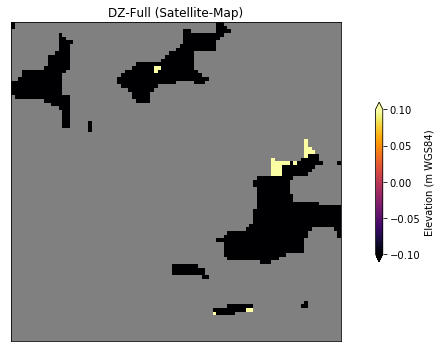

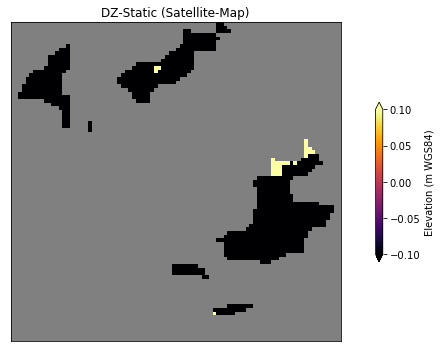

In [5]:
titles = ['DZ-Full (Satellite-Map)']
dz_full2plot = gf.dz_full
dz_full2plot.mask = dems_mask
clim = malib.calcperc(dz_full2plot, (2,98))
plot_array(dz_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='dem.png')

titles = ['DZ-Static (Satellite-Map)']
clim = malib.calcperc(gf.dz_static, (2,98))
plot_array(gf.dz_static, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='dem.png')

Text(0.5, 1, 'UTM (m)')

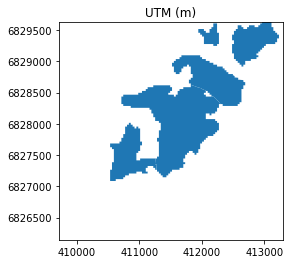

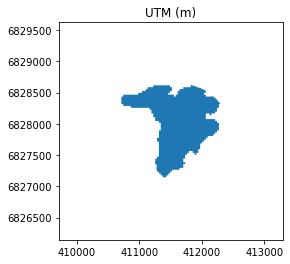

In [6]:
# Plot single glacier
rgiid = 'RGI60-' + gf.feat_fn.split('_')[0].split('.')[0].zfill(2) + '.' + gf.feat_fn.split('_')[0].split('.')[1]
glac_shp_proj = gpd.read_file(glac_shp_proj_fn)
glac_shp_single = glac_shp_proj[glac_shp_proj['RGIId'] == rgiid]
glac_shp_single = glac_shp_single.reset_index()

# Plot over region of interest
ax = glac_shp_proj.plot()
xlim = (warp_extent[0], warp_extent[2])
ylim = (warp_extent[1], warp_extent[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("UTM (m)")

ax = glac_shp_single.plot()
xlim = (warp_extent[0], warp_extent[2])
ylim = (warp_extent[1], warp_extent[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("UTM (m)")

True
dz_count: 0
(87, 90)
valid area: 0.0
0
valid area %: 0.0


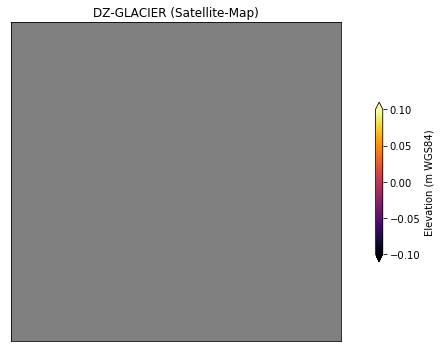

In [7]:
#Now apply glacier mask AND mask NaN values
glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
nan_mask = np.ma.masked_invalid(gf.dz)
glac_geom_mask = np.ma.mask_or(glac_geom_mask, nan_mask.mask)
gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)
gf.z2 = np.ma.array(gf.z2, mask=glac_geom_mask)
gf.dz = np.ma.array(gf.dz, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

print('dz_count:', gf.dz.count())
# print(gf.dz.compressed()))

#Compute area covered by valid pixels in m2
gf.valid_area = gf.dz.count() * gf.res[0] * gf.res[1]
#Compute percentage covered by total area of polygon
gf.valid_area_perc = 100. * (gf.valid_area / gf.glac_area)
if verbose:
    print('valid area %:', gf.valid_area_perc)

titles = ['DZ-GLACIER (Satellite-Map)']
clim = malib.calcperc(gf.dz, (2,98))
plot_array(gf.dz, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='dem.png')

In [8]:
if gf.valid_area_perc < (100. * min_valid_area_perc):
    if verbose:
        print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
#     return None

else:
    #Filter dz - throw out abs differences >150 m

    #Compute dz, volume change, mass balance and stats
    gf.z1_stats = malib.get_stats(gf.z1)
    gf.z2_stats = malib.get_stats(gf.z2)

    #Should probably take mean of z1 and z2 here
    #For cases where WV/GE is z2, maybe best to take
    z2_elev_med = gf.z2_stats[5]
    #z2_elev_min = gf.z2_stats[1]
    #z2_elev_max = gf.z2_stats[2]
    z2_elev_min, z2_elev_max = malib.calcperc(gf.z2, (0.1, 99.9))
    #z2_elev_p16 = gf.z2_stats[11]
    #z2_elev_p84 = gf.z2_stats[12]
    
    #Caluclate stats for aspect and slope using z2
    #Requires GDAL 2.1+
    gf.z2_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z2'], processing='aspect', returnma=True), mask=glac_geom_mask)
    gf.z2_aspect_stats = malib.get_stats(gf.z2_aspect)
    z2_aspect_med = gf.z2_aspect_stats[5]
    gf.z2_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z2'], processing='slope', returnma=True), mask=glac_geom_mask)
    gf.z2_slope_stats = malib.get_stats(gf.z2_slope)
    z2_slope_med = gf.z2_slope_stats[5]

    #Load timestamp array, if available
    if 'z1_date' in ds_dict:
        gf.t1 = iolib.ds_getma(ds_dict['z1_date'])
    else:
        if isinstance(gf.t1, datetime):
            gf.t1 = float(timelib.dt2decyear(gf.t1))
        #else, assume we've hardcoded decimal year
    gf.t1_mean = np.mean(gf.t1)

    if 'z2_date' in ds_dict:
        gf.t2 = iolib.ds_getma(ds_dict['z2_date'])
    else:
        if isinstance(gf.t2, datetime):
            gf.t2 = float(timelib.dt2decyear(gf.t2))
        #else, assume we've hardcoded decimal year
    gf.t2_mean = np.mean(gf.t2)

    #These should be decimal years, either grids or constants
    gf.dt = gf.t2 - gf.t1
    gf.dt_mean = np.mean(gf.dt)
    #if isinstance(gf.dt, timedelta):
    #    gf.dt = gf.dt.total_seconds()/timelib.spy
        
    #Calculate dh/dt, in m/yr
    gf.dhdt = gf.dz/gf.dt
    gf.dhdt_sum = gf.dhdt.sum()
    gf.dhdt_stats = malib.get_stats_dict(gf.dhdt)
    gf.dhdt_mean = gf.dhdt_stats['mean']
    gf.dhdt_med = gf.dhdt_stats['med']
    gf.dhdt_nmad = gf.dhdt_stats['nmad']
    
    gf.dhdt_static = gf.dz_static/gf.dt
    gf.dhdt_static_stats = malib.get_stats_dict(gf.dhdt_static)
    gf.dhdt_static_mean = gf.dhdt_static_stats['mean']
    gf.dhdt_static_med = gf.dhdt_static_stats['med']
    gf.dhdt_static_nmad = gf.dhdt_static_stats['nmad']
    
    print('STATIC ANALYSIS DOES NOT WORK FOR UNCERTAINTY HERE BECAUSE IN 1950s THE GLACIER EXCEEDED THE RGI EXTENTS')
    
    #Can estimate ELA values computed from hypsometry and typical AAR
    #For now, assume ELA is mean
    gf.z1_ela = None
    gf.z1_ela = gf.z1_stats[3]
    gf.z2_ela = gf.z2_stats[3]
    #Note: in theory, the ELA should get higher with mass loss
    #In practice, using mean and same polygon, ELA gets lower as glacier surface thins
    if verbose:
        print("ELA(t1): %0.1f" % gf.z1_ela)
        print("ELA(t2): %0.1f" % gf.z2_ela)

    if gf.z1_ela > gf.z2_ela:
        min_ela = gf.z2_ela
        max_ela = gf.z1_ela
    else:
        min_ela = gf.z1_ela
        max_ela = gf.z2_ela
    
    #Calculate uncertainty of total elevation change
    #decorrelation length
    L = 500
    Acor = np.pi*L**2
    if gf.glac_area > Acor:
        #Correction factor for sample size area
        Acorf = np.sqrt(Acor/(5*gf.glac_area))
    else:
        Acorf = 1.0

    #Std or NMAD of elevation change on stable ground, assuming we know a priori uncertainty for z1 and z2
    #dz_sigma = np.sqrt(z1_sigma**2 + z2_sigma**2)
    #dhdt_sigma = dz_sigma/gf.dt

    #This is NMAD of static pixels within buffer
    dhdt_sigma = gf.dhdt_static_nmad
    #Uncertainty of dh/dt
    gf.dhdt_sigma = Acorf * (dhdt_sigma)

    #This is percentage of valid pixels, 0-1
    #p = min(gf.valid_area_perc/100., 1.0)
    #From Brun et al, multiply uncertainty for nodata by 5x
    #p_factor = (p + 5*(1-p))
    p_factor = 1.0

    #Calculate volume change (m3/a)
    gf.dv = gf.dhdt_mean * gf.glac_area
    #gf.dv = gf.dhdt_med * gf.glac_area
    gf.dv_sum = gf.dhdt_sum*gf.res[0]*gf.res[1]
    #print(gf.dv, gf.dv_sum, (gf.dv - gf.dv_sum))

    #Volume change uncertainty (m3/a)
    gf.dv_sigma = np.sqrt((gf.dhdt_sigma*p_factor*gf.glac_area)**2 + (area_sigma_perc * gf.glac_area)**2)

    #Mass balance in mwe/a for each pixel
    gf.mb_map = gf.dhdt * rho_is
    gf.mb_map_sum = gf.mb_map.sum()
    gf.mb_map_stats = malib.get_stats_dict(gf.mb_map)
    gf.mb_map_sigma = np.ma.abs(gf.mb_map) * np.sqrt((rho_sigma/rho_is)**2 + (gf.dhdt_sigma/gf.dhdt)**2)
    gf.mb_map_sigma_stats = malib.get_stats_dict(gf.mb_map_sigma)

    #This is estimate for polygon mb in mwea
    gf.mb_mean = gf.mb_map_stats['mean']
    #This is average mb uncertainty, does not include area uncertainty
    gf.mb_mean_sigma = gf.mb_map_sigma_stats['mean']
    gf.mb_med = gf.mb_map_stats['med']
    gf.mb_med_sigma = gf.mb_map_sigma_stats['med']

    #Total mass balance for polygon in m3wea
    #previously gf.mb_mean_totalarea
    gf.mb_total = gf.dv * rho_is
    gf.mb_total_sigma = np.sqrt((gf.dv_sigma*rho_is)**2 + (rho_sigma*gf.dv)**2)

    """
    # This attempted to assign different densities above and below ELA
    if gf.z1_ela is None:
        gf.mb = gf.dhdt * rho_is
    else:
        #Initiate with average density
        gf.mb = gf.dhdt*(rho_is + rho_f)/2.
        #Everything that is above ELA at t2 is elevation change over firn, use firn density
        accum_mask = (gf.z2 > gf.z2_ela).filled(0).astype(bool)
    gf.mb[accum_mask] = (gf.dhdt*rho_f)[accum_mask]
    #Everything that is below ELA at t1 is elevation change over ice, use ice density
    abl_mask = (gf.z1 <= gf.z1_ela).filled(0).astype(bool)
    gf.mb[abl_mask] = (gf.dhdt*rho_is)[abl_mask]
    #Everything in between, use average of ice and firn density
    #mb[(z1 > z1_ela) || (z2 <= z2_ela)] = dhdt*(rhois + rho_f)/2.
    #Linear ramp
    #rho_f + z2*((rho_is - rho_f)/(z2_ela - z1_ela))
    #mb = np.where(dhdt < ela, dhdt*rho_i, dhdt*rho_s)
    """

    #Old approach
    #This is mb uncertainty map
    #gf.mb_sigma = np.ma.abs(gf.mb) * np.sqrt((rho_sigma/rho_is)**2 + (gf.dhdt_sigma/gf.dhdt)**2)
    #gf.mb_sigma_stats = malib.get_stats(gf.mb_sigma)
    #This is average mb uncertainty
    #gf.mb_mean_sigma = gf.mb_sigma_stats[3]

    #Now calculate mb for entire polygon
    #gf.mb_mean_totalarea = gf.mb_mean * gf.glac_area
    #Already have area uncertainty as percentage, just use directly
    #gf.mb_mean_totalarea_sigma = np.ma.abs(gf.mb_mean_totalarea) * np.sqrt((gf.mb_mean_sigma/gf.mb_mean)**2 + area_sigma_perc**2)

    #z2_elev_med, z2_elev_min, z2_elev_max, z2_elev_p16, z2_elev_p84, \
    outlist = [gf.glacnum, gf.cx, gf.cy, \
            z2_elev_med, z2_elev_min, z2_elev_max, \
            z2_slope_med, z2_aspect_med, \
            gf.dhdt_mean, gf.dhdt_sigma, \
            gf.mb_mean, gf.mb_mean_sigma, \
            gf.glac_area, gf.mb_total, gf.mb_total_sigma, \
            gf.t1_mean, gf.t2_mean, gf.dt_mean, gf.valid_area_perc]

    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
        if 'ice_thick' in ds_dict:
            #Load ice thickness
            gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
            gf.H_mean = gf.H.mean()
        #These should be NaN or None
        outlist.append(gf.H_mean)

        if 'debris_thick' in ds_dict:
            gf.debris_thick = np.ma.array(iolib.ds_getma(ds_dict['debris_thick']), mask=glac_geom_mask)
            gf.debris_thick_mean = gf.debris_thick.mean()
        outlist.append(gf.debris_thick_mean)

        if 'debris_class' in ds_dict:
            #Load up debris cover maps
            #Classes are: 1 = clean ice, 2 = debris, 3 = pond
            gf.debris_class = np.ma.array(iolib.ds_getma(ds_dict['debris_class']), mask=glac_geom_mask)

            #Compute debris/pond/clean percentages for entire polygon
            if gf.debris_class.count() > 0:
                gf.perc_clean = 100. * (gf.debris_class == 1).sum()/gf.debris_class.count()
                gf.perc_debris = 100. * (gf.debris_class == 2).sum()/gf.debris_class.count()
                gf.perc_pond = 100. * (gf.debris_class == 3).sum()/gf.debris_class.count()
        outlist.extend([gf.perc_debris, gf.perc_pond, gf.perc_clean])

        if 'vx' in ds_dict and 'vy' in ds_dict:
            #Load surface velocity maps
            gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
            gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
            gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
            gf.vm_mean = gf.vm.mean()

            if gf.H is not None:
                #Compute flux
                gf.Q = gf.H * v_col_f * np.array([gf.vx, gf.vy])
                #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                #Want x-derivative of x component
                gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

                #gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
                        #+ v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                #Should smooth divQ, better handling of data gaps
        outlist.append(gf.vm_mean)

    if verbose:
        print('Area [km2]:', gf.glac_area / 1e6)
        print('Mean mb: %0.2f +/- %0.2f mwe/yr' % (gf.mb_mean, gf.mb_mean_sigma))
        print('Sum/Area mb: %0.2f mwe/yr' % (gf.mb_total/gf.glac_area))
        print('Mean mb * Area: %0.2f +/- %0.2f m3we/yr' % (gf.mb_total, gf.mb_total_sigma))
#         print('Sum mb: %0.2f m3we/yr' % gf.mb_total)
        print('-------------------------------')
    
    #Write out mb stats for entire polygon - in case processing is interupted
    #out = np.array(outlist, dtype=float)
    out = np.full(len(out_fmt), np.nan)
    out[0:len(outlist)] = np.array(outlist, dtype=float)
    #Note, need a 2D array here, add 0 axis

    print(out)

    np.savetxt(out_csv_fn, out[np.newaxis,:], fmt=out_fmt, delimiter=',', header=out_header, comments='')
        

Not enough valid pixels. 0.0% percent of glacier polygon area


In [13]:
#Do AED for all
#Compute mb using scaled AED vs. polygon
#Check for valid pixel count vs. feature area, fill if appropriate

if mb_plot and (gf.glac_area_km2 > min_glac_area_writeout):
    print('plot?')
#     dz_clim = (-2.0, 2.0)
#     if site == 'hma':
#         dz_clim = (-3.0, 3.0)
#     z_bin_edges = hist_plot(gf, outdir, bin_width=bin_width, dz_clim=dz_clim)
#     gf.z1_hs = geolib.gdaldem_mem_ds(ds_dict['z1'], processing='hillshade', returnma=True)
#     gf.z2_hs = geolib.gdaldem_mem_ds(ds_dict['z2'], processing='hillshade', returnma=True)
#     map_plot(gf, z_bin_edges, outdir, dz_clim=dz_clim)

plot?
